In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config, maskedModel, ResBlock, FocalLoss, FocalLossSoft, adjacent_label_smoothing #noqa
torch.cuda.is_available()

True

In [2]:
receiver_stat_cols = [
    "dense_depth",
    "receptions_roll",
    "targets_roll",
    "receiving_yards_roll",
    "receiving_tds_roll",
    "receiving_air_yards_roll",
    "receiving_yards_after_catch_roll",
    "receiving_first_downs_roll",
    "target_share_roll",
    "air_yards_share_roll",
    "fantasy_points_ppr_roll",
    "yards_per_target_roll",
    "yards_per_catch_roll",
]

qb_stat_cols = [
    "completions_roll",
    "attempts_roll",
    "passing_yards_roll",
    "passing_tds_roll",
    "passing_interceptions_roll",
    "sacks_suffered_roll",
    "sack_yards_lost_roll",
    "passing_air_yards_roll",
    "passing_yards_after_catch_roll",
    "offense_snaps_roll",
    "offense_pct_roll",
    "completion_pct_roll",
]

team_stat_cols = [
    "completions_team_roll",
    "attempts_team_roll",
    "carries_team_roll",
    "passing_yards_team_roll",
    "rushing_yards_team_roll",
    "pass_pct_team_roll",
]
opp_stat_cols = [
    "completions_opp_roll",
    "attempts_opp_roll",
    "carries_opp_roll",
    "passing_yards_opp_roll",
    "rushing_yards_opp_roll",
    "pass_pct_opp_roll",
]

game_context_cols = [
    "yardline_100",
    "ydstogo",
    "down",
    "goal_to_go",
    # "posteam_score",
    # "defteam_score",
    # "score_differential",
    #'quarter_seconds_remaining',
    #'half_seconds_remaining',
    #'game_seconds_remaining',
    "wind",
    # "temp",
    "spread_line",
    "total_line",
]

x_cols = (
    game_context_cols
    + [
        "is_first_down",
        "dense_depth",
        "receptions_roll",
        "targets_roll",
        "receiving_yards_roll",
        "receiving_tds_roll",
        "receiving_air_yards_roll",
        "receiving_yards_after_catch_roll",
        "receiving_first_downs_roll",
        "target_share_roll",
        "air_yards_share_roll",
        "fantasy_points_ppr_roll",
        "yards_per_target_roll",
        "yards_per_catch_roll",
        #"completions_roll",
        #"attempts_roll",
        "passing_yards_roll",
        "passing_tds_roll",
        "passing_interceptions_roll",
        #"sacks_suffered_roll",
        #"sack_yards_lost_roll",
        "passing_air_yards_roll",
        "passing_yards_after_catch_roll",
        #"offense_snaps_roll",
        #"offense_pct_roll",
        "completion_pct_roll",
    ]
    + ["passing_yards_opp_roll"]
)

In [3]:
Quack.query(f"""
select * from pbp
			limit 1000
			""")

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,34.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,away,NYG,...,0.0,0.0,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,70.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,away,NYG,...,0.0,0.0,0.812263,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,106.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,away,NYG,...,0.0,0.0,-0.076852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,131.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,away,NYG,...,0.0,0.0,-0.765240,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,148.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,away,NYG,...,0.0,0.0,-1.311643,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3021.0,2000_01_DET_NO,2000090304,NO,DET,REG,1,DET,away,NO,...,0.0,0.0,-1.268602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,3042.0,2000_01_DET_NO,2000090304,NO,DET,REG,1,DET,away,NO,...,0.0,0.0,0.772797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,3067.0,2000_01_DET_NO,2000090304,NO,DET,REG,1,NO,home,DET,...,0.0,0.0,-0.445895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,3100.0,2000_01_DET_NO,2000090304,NO,DET,REG,1,NO,home,DET,...,0.0,0.0,-0.206995,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
passes = Quack.query(f"""
select
    pbp.game_id,
    pbp.air_yards,
    pbp.yards_after_catch as yac,
    pbp.first_down,
    pbp.touchdown,
    case when pbp.air_yards >= pbp.yardline_100 then 1 else 0 end as air_td,
    case when pbp.air_yards >= pbp.ydstogo then 1 else 0 end as air_fd,
    greatest(least(pbp.air_yards + 40, 139), 1) as air_yards_shifted,
    greatest(least(pbp.yards_after_catch + 40, 139), 1) as yac_shifted,
    case when ydstogo = 10 then 1 else 0 end as is_first_down,
    case when pbp.ydstogo < 3 then 1 else 0 end as short_to_first,
	{Quack.select_columns(game_context_cols, alias='pbp', coalesce=True)},
	{Quack.select_columns(team_stat_cols, alias='t', coalesce=True)},
	{Quack.select_columns(opp_stat_cols, alias='o', coalesce=True)},
	{Quack.select_columns(receiver_stat_cols, alias='r', coalesce=True)},
	{Quack.select_columns(qb_stat_cols, alias='qb', coalesce=True)}
from pbp inner join team_feats as t
    on
        pbp.posteam = t.team
        and pbp.game_id = t.game_id
inner join opp_feats as o
    on
        pbp.defteam = o.opponent_team
        and pbp.game_id = o.game_id
inner join player_weekly_agg as r
    on pbp.game_id = r.game_id
        and pbp.receiver_player_id = r.gsis_id
        and pbp.posteam = r.team
inner join player_weekly_agg as qb
    on pbp.game_id = qb.game_id
        and pbp.passer_player_id = qb.gsis_id
        and pbp.posteam = qb.team
        and pbp.pass = 1
        and pbp.pass_attempt = 1
        and pbp.down is not null
        and pbp.play_type = 'pass'
		
		;

""")

X = passes[x_cols]
y = passes['air_yards_shifted']
Xyac = passes[x_cols + ['air_yards']]
yyac = passes['yac_shifted']
obs = len(X)
num_feats = len(x_cols)
y.shape

(210256,)

In [5]:
X

,yardline_100,ydstogo,down,goal_to_go,wind,spread_line,total_line,is_first_down,dense_depth,receptions_roll,...,fantasy_points_ppr_roll,yards_per_target_roll,yards_per_catch_roll,passing_yards_roll,passing_tds_roll,passing_interceptions_roll,passing_air_yards_roll,passing_yards_after_catch_roll,completion_pct_roll,passing_yards_opp_roll
0,67.0,8.0,2.0,0.0,10,-3.5,42.5,0,1,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.999096
1,34.0,6.0,2.0,0.0,10,-3.5,42.5,0,2,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.999096
2,34.0,3.0,2.0,0.0,0,3.5,49.5,0,1,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.095233
3,30.0,17.0,3.0,0.0,11,3.0,41.5,0,1,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.938858
4,46.0,10.0,1.0,0.0,9,4.0,51.0,1,0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.009440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210251,53.0,10.0,2.0,0.0,0,2.5,48.5,1,2,5.463745,...,13.476846,6.562810,9.223701,234.429917,1.410738,1.048111,264.39842,104.961613,0.650537,1.164598
210252,45.0,27.0,4.0,0.0,0,2.5,48.5,0,1,5.495113,...,17.172864,8.316220,12.456498,234.429917,1.410738,1.048111,264.39842,104.961613,0.650537,1.164598
210253,40.0,22.0,3.0,0.0,0,2.5,48.5,0,0,4.547545,...,12.215629,7.582034,10.824976,234.429917,1.410738,1.048111,264.39842,104.961613,0.650537,1.164598
210254,75.0,7.0,3.0,0.0,0,2.5,48.5,0,1,0.344206,...,1.578373,6.318958,4.372758,234.429917,1.410738,1.048111,264.39842,104.961613,0.650537,1.164598


In [6]:
x_cols

['yardline_100',
 'ydstogo',
 'down',
 'goal_to_go',
 'wind',
 'spread_line',
 'total_line',
 'is_first_down',
 'dense_depth',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'receiving_air_yards_roll',
 'receiving_yards_after_catch_roll',
 'receiving_first_downs_roll',
 'target_share_roll',
 'air_yards_share_roll',
 'fantasy_points_ppr_roll',
 'yards_per_target_roll',
 'yards_per_catch_roll',
 'passing_yards_roll',
 'passing_tds_roll',
 'passing_interceptions_roll',
 'passing_air_yards_roll',
 'passing_yards_after_catch_roll',
 'completion_pct_roll',
 'passing_yards_opp_roll']

In [7]:
print(y.min(),y.max())

1.0 139.0


In [8]:
passes['air_td'].value_counts(normalize=True).reset_index().sort_values(by='air_td').head(20)

,air_td,proportion
0,0,0.932316
1,1,0.067684


In [9]:
passes[x_cols].min()

yardline_100                         1.000000
ydstogo                              1.000000
down                                 1.000000
goal_to_go                           0.000000
wind                                 0.000000
spread_line                        -18.000000
total_line                          28.500000
is_first_down                        0.000000
dense_depth                          0.000000
receptions_roll                      0.000000
targets_roll                         0.000000
receiving_yards_roll                -5.000000
receiving_tds_roll                   0.000000
receiving_air_yards_roll           -24.000000
receiving_yards_after_catch_roll    -3.000000
receiving_first_downs_roll           0.000000
target_share_roll                    0.000000
air_yards_share_roll                -0.380952
fantasy_points_ppr_roll             -1.800000
yards_per_target_roll                0.000000
yards_per_catch_roll                -0.500000
passing_yards_roll                

In [22]:
def train_model(X, y, n_in, n_out,n_hidden=64, epochs=20, batch_size=128, model=None):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	print(device)
	X = X.to(device)
	y = y.to(device)

	print('tensors loading')
	smoothed_y = adjacent_label_smoothing(y,X[:,0], num_classes=140, smoothing = 0.25, k=5)

	if not model:
		model = maskedModel(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	criterion = FocalLossSoft(gamma=4)
	criterion = nn.CrossEntropyLoss()
	td_criterion = nn.BCELoss()
	fd_criterion = nn.BCELoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.004)

	num_samples = X.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 10  # 10% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices
	print('splitting batches')
	Xtr = X[train_indices]
	Xtst = X[test_indices]
	train_y = y[train_indices]
	train_y_smooth = smoothed_y[train_indices]
	test_y =  y[test_indices]
	test_y_smooth = smoothed_y[test_indices]
	train_is_td = (train_y == (40 +  Xtr[:,0])).float()
	train_is_fd = (train_y >= (40 + Xtr[:,1])).float()
	print(train_is_fd.mean())
	print(train_is_td.mean())
	# Training loop
	try:
		for epoch in range(epochs):
			model.train()
			permutation = torch.randperm(Xtr.size(0))
			epoch_mean_loss = 0
			epoch_class_loss = 0
			yard_idx = torch.arange(n_out, device=device).unsqueeze(0)

			for i in range(0, Xtr.size(0), batch_size):
				batch_idx = permutation[i:i + batch_size]
				batch_x, batch_y = Xtr[batch_idx], train_y[batch_idx]
				batch_y_smooth =  train_y_smooth[batch_idx]
				batch_td, batch_fd = train_is_td[batch_idx], train_is_fd[batch_idx]

				optimizer.zero_grad()
				outputs = model(batch_x)  # Shape: [batch_size, n_out]
				probs = torch.softmax(outputs, dim=1)

				fd_mask = yard_idx >= (batch_x[:,1] + 40).unsqueeze(1) # [9, 140]
				fd_output = (probs * fd_mask).sum(1).clamp(0, 1)
				td_mask = yard_idx >= (batch_x[:,0] + 40).unsqueeze(1)  # [9, 140]
				td_output = (probs * td_mask).sum(1).clamp(0, 1)
				td_loss = td_criterion(td_output, batch_td) * 0.5
				fd_loss = fd_criterion(fd_output, batch_fd) * 0.5


				probs_mean = (torch.arange(0,n_out, dtype=torch.float32).to(device) * probs).sum(1)
				classifier_loss = criterion(outputs, batch_y_smooth) * 6
				mean_loss =  criterion_mse(probs_mean, batch_y.float()) * 2.25
				loss = classifier_loss + mean_loss + td_loss + fd_loss
				#loss = classifier_loss + td_loss
				loss.backward()
				optimizer.step()

				epoch_mean_loss += mean_loss.item()
				epoch_class_loss += classifier_loss.item()
			n_batches = len(range(0, Xtr.size(0), batch_size))
			print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/n_batches:.4f}, MSE Loss: {epoch_mean_loss/n_batches:.4f}")


			model.eval()
			with torch.no_grad():
				test_preds = model(Xtst)
				test_loss = criterion(test_preds, test_y).item() 
				accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
			print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
	except Exception as e:
		print(fd_output.max(), fd_output.min())
		raise e
	return model

In [23]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

n_in = num_feats
n_hidden = 512
n_out = 140

air_yards_model = train_model(X_tensor, y_tensor, n_in, n_out, n_hidden=n_hidden, epochs = 20, batch_size=2048) # 3.327, 0.0865
air_yards_model = air_yards_model.to('cpu')
#Test Loss: 3.6856, Test Accuracy: 0.0827
#Test Loss: 3.3504, Test Accuracy: 0.1119
#Epoch 20/20, Classifier Loss: 28.4379, MSE Loss: 38.0815
#Test Loss: 2.7789, Test Accuracy: 0.1603
#Epoch 20/20, Classifier Loss: 20.7130, MSE Loss: 75.9770 focal loss soft
#Test Loss: 3.0928, Test Accuracy: 0.1557
#Epoch 20/20, Classifier Loss: 20.7351, MSE Loss: 75.9967 #512 layers, less lr and weight decay
#Test Loss: 2.9591, Test Accuracy: 0.1546
#Epoch 20/20, Classifier Loss: 36.1280, MSE Loss: 187.0707
#Test Loss: 3.3475, Test Accuracy: 0.1122

cuda
tensors loading
splitting batches
tensor(0.4390, device='cuda:0')
tensor(0.0678, device='cuda:0')
Epoch 1/20, Classifier Loss: 363.8260, MSE Loss: 406.1411
Test Loss: 47596.5469, Test Accuracy: 0.0636
Epoch 2/20, Classifier Loss: 667.1227, MSE Loss: 258.4656
Test Loss: 47646.0000, Test Accuracy: 0.0859
Epoch 3/20, Classifier Loss: 1895.3559, MSE Loss: 257.0445
Test Loss: 48038.7734, Test Accuracy: 0.0612
Epoch 4/20, Classifier Loss: 8578.4876, MSE Loss: 521.3065
Test Loss: 49225.3594, Test Accuracy: 0.0218
Epoch 5/20, Classifier Loss: 31385.9004, MSE Loss: 744.2423
Test Loss: 51480.9961, Test Accuracy: 0.0227
Epoch 6/20, Classifier Loss: 41222.2299, MSE Loss: 1552.3419
Test Loss: 51811.5430, Test Accuracy: 0.0290
Epoch 7/20, Classifier Loss: 53048.1733, MSE Loss: 1351.4766
Test Loss: 52883.6836, Test Accuracy: 0.0272
Epoch 8/20, Classifier Loss: 55729.7820, MSE Loss: 1486.2179
Test Loss: 53387.0430, Test Accuracy: 0.0184
Epoch 9/20, Classifier Loss: 64133.2672, MSE Loss: 1666.3244

In [19]:
def get_ydl_chance(probs, ydl):

	cols = np.arange(probs.shape[1])
	mask = cols >= ydl[:, None]   # shape (3, 10), True where col >= start
	sums = (probs * mask).sum(axis=1).mean()
	return sums

def sample_model_yardline(yard, down, ydstogo=None):
	sample = passes.loc[(passes.yardline_100.between(yard,yard)) & (passes.down.between(1,3))].reset_index(drop=True)
	if ydstogo:
		sample = sample.loc[sample.ydstogo == ydstogo].reset_index(drop=True)
	true_first = (sample['air_yards'] >= sample['ydstogo']).mean().item()
	true_td = sample['air_td'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['air_yards']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = air_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	probs = probs.mean(axis=0)

	plt.hist(y, range(-40,101),width=1, density=True, alpha=0.8, label='actual')

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 40) @ probs
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	
	return probs

def plot_model(yard,down, ydstogo=None):
	probs = sample_model_yardline(yard, down, ydstogo)
	plt.bar(range(-40, 100), probs, width=1, alpha=0.5, align="edge", label="model", color='r')

	# Add index labels on top of bars
	for i, p in enumerate(probs):
		yard_val = -40 + i
		if -10 <= yard_val <= yard:  # only label visible range
			plt.text(yard_val + 0.5, p + 0.002, str(yard_val),
					ha='center', va='bottom', fontsize=8, rotation=90)

	if ydstogo:
		plt.title(f'{ydstogo} yards to go')
		plt.axvline(x=ydstogo, color='g', linestyle='-.')
	plt.legend()
	plt.xlim(-15,yard+25)
	plt.show()

true_first=0.42, true_td=0.08
fd_model=0.47, td_model=0.01
Actual mean: 8.61, Model mean: 8.33
number of datapoints: 1786


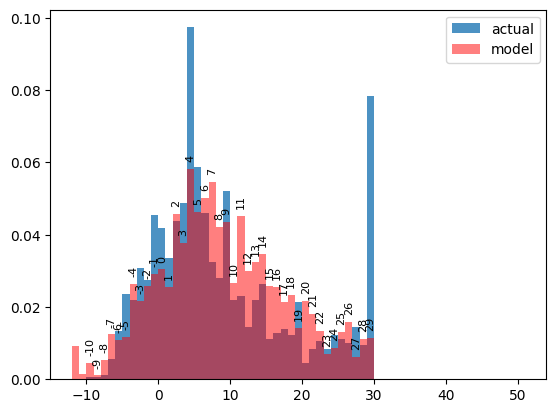

In [21]:
#for i in range(1,11, 2):
	#plot_model(38, 3, i)
plot_model(29,1)

In [14]:
model_path = "models/air_yards.pt"
torch.save(air_yards_model.state_dict(), model_path)


feature_config = {
	'air_yards_model' :{
	'feature_cols':x_cols,
	'model_path': model_path,
	'n_in':n_in,
	'n_hidden':n_hidden,
	'n_out':n_out
}
}

update_config(feature_config)